In [13]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import jax
import jax.numpy as jnp
from flax import nnx
import optax
import math
from IPython import display

import plot_lib as pl
import importlib
importlib.reload(pl)


pl.set_default()

### Create synthetic data

In [2]:
seed = 12345
key = jax.random.PRNGKey(seed)

N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

In [3]:
X = jnp.zeros((N * C, D))
y = jnp.zeros(N * C, dtype=jnp.int32)

X_list = []
y_list = []

key, subkey = jax.random.split(key)
for c in range(C):
    t = jnp.linspace(0, 1, N)
    inner_var = jnp.linspace(
        (2 * math.pi / C) * c,
        (2 * math.pi / C) * (2 + c),
        N
    ) + jax.random.normal(jax.random.fold_in(subkey, c), (N,)) * 0.2
    
    X_c = jnp.stack([t * jnp.sin(inner_var), t * jnp.cos(inner_var)], axis=1)
    y_c = jnp.full((N,), c, dtype=jnp.int32)
    
    X_list.append(X_c)
    y_list.append(y_c)

X = jnp.concatenate(X_list, axis=0)
y = jnp.concatenate(y_list, axis=0)

print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)

Shapes:
X: (3000, 2)
y: (3000,)


In [4]:
num_classes = len(jnp.unique(y))
print(f"num_classes: {num_classes}")

num_classes: 3


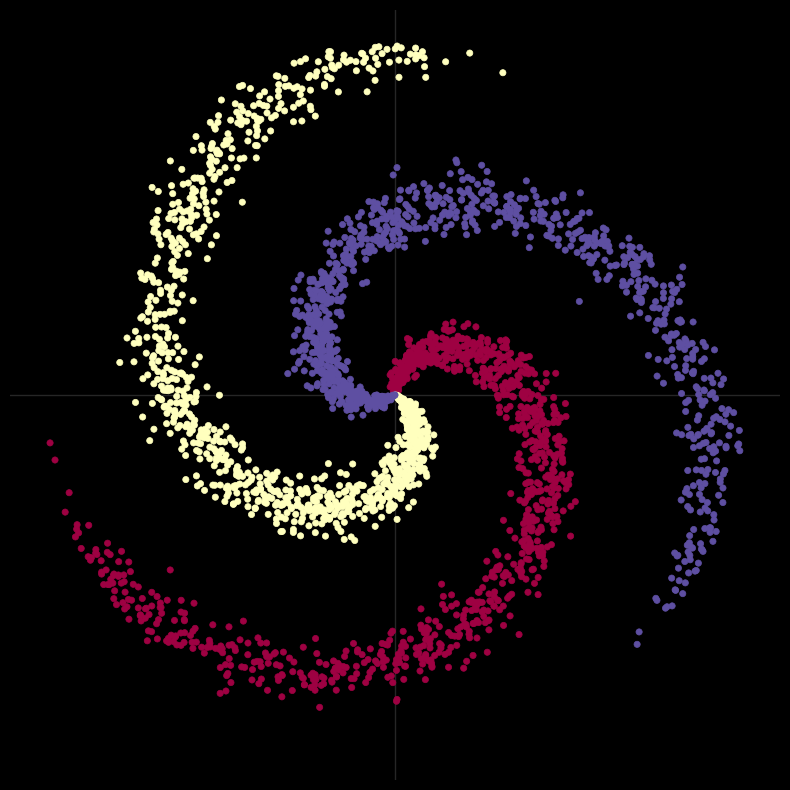

In [5]:
plot_data(X, y)

### Model: FeedForward Network

In [6]:
class FeedForward(nnx.Module):
    def __init__(self, din, dhidden, dout, rngs: nnx.Rngs):
        self.fc1 = nnx.Linear(din, dhidden, rngs=rngs)
        self.fc2 = nnx.Linear(dhidden, dout, rngs=rngs)
        
    def __call__(self, x):
        out = self.fc1(x)
        out = nnx.relu(out)
        out = self.fc2(out)
        return out

model = FeedForward(D, H, C, rngs=nnx.Rngs(seed))
nnx.display(model)

[plot_model] data shape: (48400, 2)
[plot_model] Z shape: (48400, 3)


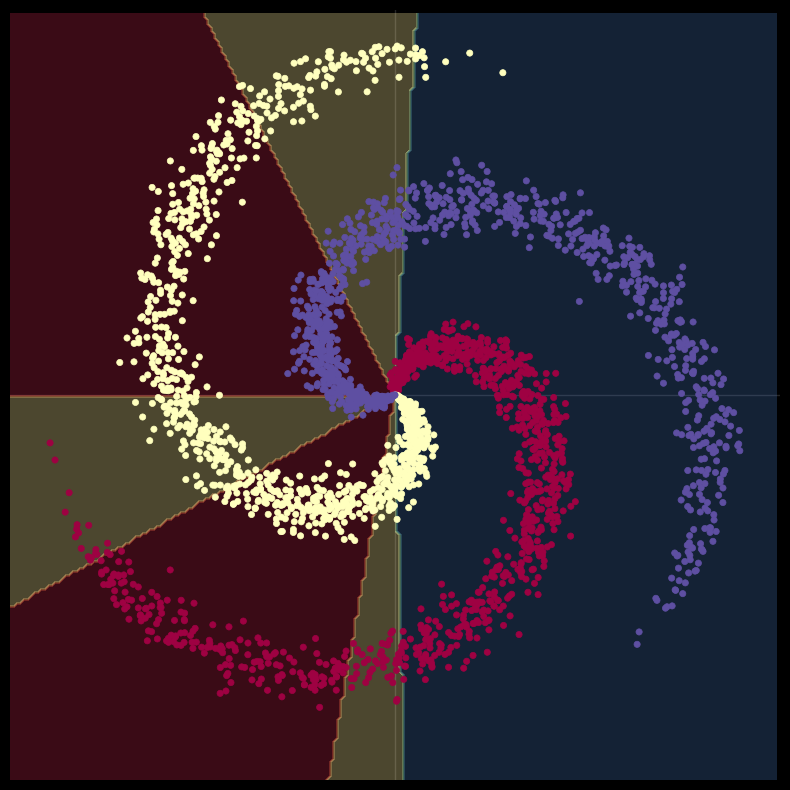

In [14]:
# plot model (before training)
pl.plot_model(X, y, model)

In [8]:
# Forward pass
logit_hat = model(X)

# Loss function
loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logit_hat, y))
print(f"Loss: {loss}")

Loss: 1.0887233018875122


### Training

In [ ]:
learning_rate = 1e-3
optimizer = nnx.Optimizer(model, optax.adam(learning_rate), wrt=nnx.Param)

@nnx.jit
def train_step(model, optimizer, X, y):
    def loss_fn(model):
        logits = model(X)
        return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, y))
    
    grad = nnx.grad(loss_fn)(model)
    optimizer.update(grad)

# Training loop
for i in range(1000):
    train_step(model, optimizer, X, y)
    if i % 100 == 0:
        logits = model(X)
        loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, y))
        print(f"Iteration {i}, Loss: {loss}")

TypeError: Missing required argument `grads`. As of Flax 0.11.0 update requires both (model, grads) arguments to be passed. If you want to keep the previous use nnx.ModelAndOptimizer instead of nnx.Optimizer.

In [ ]:
# Final model visualization
plot_model(X, y, model)